<a href="https://colab.research.google.com/github/tevfik-erkut/ML_mixture/blob/main/Prophet-updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

I will take a sample of last 1000 rows for building my model.

In [2]:
df = pd.read_csv("/content/spy.csv")
# Converting date object into datetime object for further use.
df.Date = pd.to_datetime(df.Date)
df = df[-1000:]

In [11]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
6029,2017-01-06,226.529999,227.750000,225.899994,227.210007,210.722473,71559900
6030,2017-01-09,226.910004,227.070007,226.419998,226.460007,210.026917,46939700
6031,2017-01-10,226.479996,227.449997,226.009995,226.460007,210.026917,63771900
6032,2017-01-11,226.360001,227.100006,225.589996,227.100006,210.620483,74650000
6033,2017-01-12,226.500000,226.750000,224.960007,226.529999,210.091797,72113200


## Exploratary Data Analysis

I'm choosing Close variable to build my model on. Now, I wonder if any other variables have some relation with it?

In [12]:
df.corr()["Close"]

Open         0.997385
High         0.997845
Low          0.998214
Close        1.000000
Adj Close    0.997246
Volume      -0.165233
Name: Close, dtype: float64

Surely, It's expected to see that Open, High, Low, Close and Adj Close features are highly correlated with each other. But volume? Let's plot them and seek for a relationship between them!

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


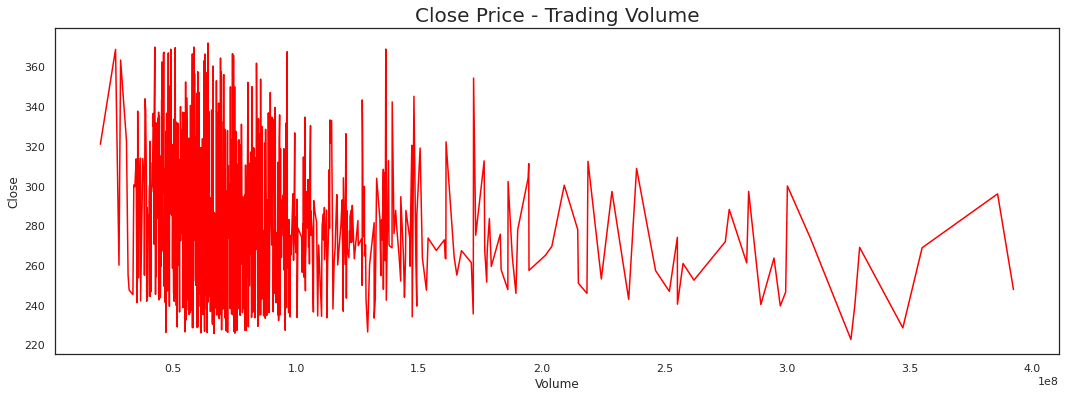

In [10]:
import seaborn as sns

sns.set(rc={'figure.figsize':(18,6)})
sns.set_style("white")
sns.lineplot(df.Volume,df.Close, color = "red").set_title("Close Price - Trading Volume", fontsize =20);

WOW! It's quite clear that when the volume decreases, price can move so fast! Contrarily, when the volume is big, price movements are relatively small. So I wouldn't be wrong If I say small volumes indicate a volatile market.

In [13]:
# Let's set up our dataframe for forecasting!

df_forecast = df.sort_values("Date")
df_forecast = df_forecast.set_index("Date")
df_forecast = df_forecast['Close'].to_frame()
df_forecast

,Close
Date,
2017-01-06,227.210007
2017-01-09,226.460007
2017-01-10,226.460007
2017-01-11,227.100006
2017-01-12,226.529999
...,...
2020-12-18,369.179993
2020-12-21,367.859985
2020-12-22,367.239990


Let's make a stationary test! 

In [ ]:
from statsmodels.tsa.stattools import adfuller

X = df_forecast.Close
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.276903
p-value: 0.639672


Null hyphotesis of Augmented Dicker Fuller says the series are not stationary. And we dont have enough evidence to reject h0 hypothesis with %95 because p-value is above 0.05. In other words, this dataset is not stationary. Therefore I will apply difference method.

Now, It's time for plotting decompositions!

<Figure size 1080x1080 with 0 Axes>

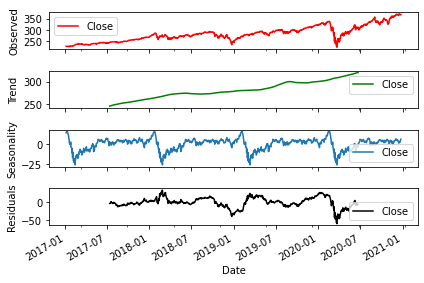

In [ ]:
result = seasonal_decompose(df_forecast, freq = 260)
plt.figure(figsize = (15,15))
fig, axes = plt.subplots(4, 1, sharex=True)

result.observed.plot(ax = axes[0], color='r')
axes[0].set_ylabel('Observed')

result.trend.plot(ax = axes[1], color='g')
axes[1].set_ylabel('Trend')

result.seasonal.plot(ax = axes[2])
axes[2].set_ylabel('Seasonality')

result.resid.plot(ax = axes[3], color='k')
axes[3].set_ylabel('Residuals')
plt.tight_layout()

Let's move on to modelling part

In [14]:
X = df_forecast.values
size = int(len(X) * 0.9)
train, test = df_forecast[0:size], df_forecast[size:len(X)]

## ARMA Model

I'm starting with ARMA model. ARMA name comes from Auto-Regressive and Moving Average. Which are basically explains what ARMA uses when forecasting.

In [15]:
from statsmodels.tsa.arima_model import ARIMA

ARMA_model = ARIMA(endog=train, order=(3, 0, 7))
results = ARMA_model.fit()
print(results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  900
Model:                     ARMA(3, 7)   Log Likelihood               -2333.798
Method:                       css-mle   S.D. of innovations              3.225
Date:                Mon, 11 Jul 2022   AIC                           4691.595
Time:                        21:20:01   BIC                           4749.224
Sample:                             0   HQIC                          4713.610
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         276.4395     17.829     15.505      0.000     241.495     311.384
ar.L1.Close    -0.5508      0.062     -8.908      0.000      -0.672      -0.430
ar.L2.Close     0.7490      0.030     25.304    

It's time for forecasting the test set. ( 900 - 1000, around 3 months)

In [16]:
forecasted_values = results.predict(start=900, end=999)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


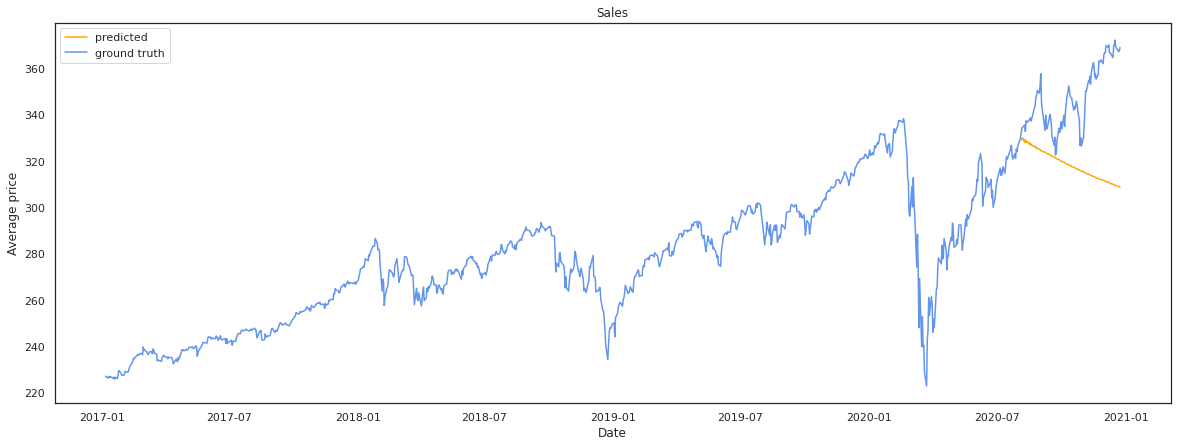

In [19]:
plt.figure(figsize = (20,7))
plt.plot(test.index, forecasted_values, color='orange', label='predicted')
plt.plot(df_forecast.index, df_forecast, color='cornflowerblue', label='ground truth')


plt.legend(loc='best')
plt.title(f'Sales')
plt.xlabel('Date')
plt.ylabel('Average price')
plt.show()

ARMA model has predicted a drop in price. It's quite clear that using ARMA model would not be a good option, I'm afraid.

## SARIMA

What's SARIMA? And why It is different from ARIMA?

Well, ARIMA and SARIMA are both algorithms for forecasting. ARIMA takes into account the past values (autoregressive, moving average) and predicts future values based on that. However, SARIMA similarly uses past values but also takes into account any seasonality patterns.

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Text(0, 0.5, 'Volume')

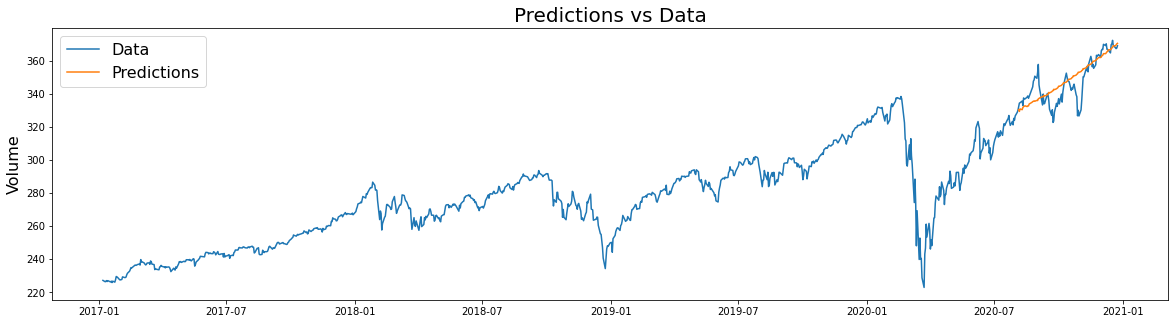

In [ ]:
mod = SARIMAX(train,
            order=(9, 3, 8), # p d q
            seasonal_order=(2, 1, 10, 5),
            enforce_stationarity=False,
            enforce_invertibility=False)
results = mod.fit()

predictions = results.forecast(len(test))
predictions = pd.DataFrame(predictions).set_index(test.index).iloc[:,0]
plt.figure(figsize=(20,5))

plt.plot(df_forecast)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Predictions vs Data', fontsize=20)
plt.ylabel('Volume', fontsize=16)

After trying many combinations on my own for p d q m parameters, the result is like this. Our SARIMA model has predicted an upwards trend.

## META - PROPHET


Prophet is an additive regression model with a piecewise linear or logistic growth curve trend. It includes a yearly seasonal component modeled using Fourier series and a weekly seasonal component modeled using dummy variables. And It's very good!


I should create some features for Prophet

In [21]:
df_forecast= df[["Date", "Close"]]
df_forecast.columns = ["date", "Close"]
df_forecast.date = pd.to_datetime(df_forecast.date)
df_forecast = df_forecast.set_index("date")
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df_forecast, label='Close')

features_and_target = pd.concat([X, y], axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


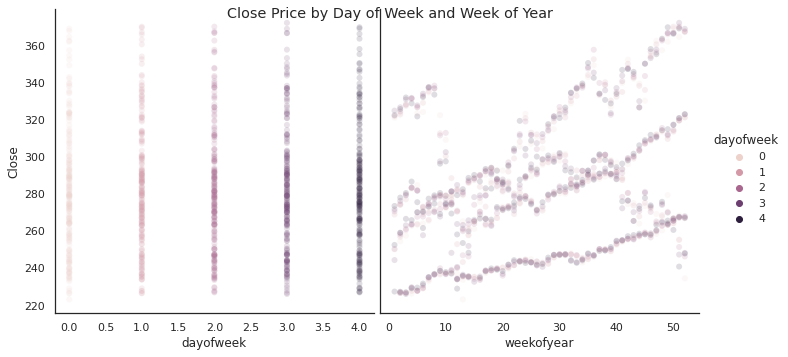

In [22]:
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
sns.pairplot(features_and_target.dropna(),
             hue='dayofweek',
             x_vars=['dayofweek',
                     'weekofyear'],
             y_vars='Close',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Close Price by Day of Week and Week of Year')
plt.show()
plt.style.use('fivethirtyeight') # For plots

In [23]:
split_date = '01-Mar-2020'
pjme_train = df_forecast.loc[df_forecast.index <= split_date].copy()
pjme_test = df_forecast.loc[df_forecast.index > split_date].copy()
from fbprophet import Prophet
model = Prophet(weekly_seasonality = True)
model.fit(pjme_train.reset_index() \
              .rename(columns={'date':'ds',
                               'Close':'y'}))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Renaming columns to "ds" and "y" is a must for using Prophet

In [24]:
# Prediction on training set with model
pjme_test_fcst = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'date':'ds'}))

In [25]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-02,322.325851,322.921582,333.752985,322.325851,322.325851,6.350741,6.350741,6.350741,-2.128873,-2.128873,-2.128873,8.479614,8.479614,8.479614,0.0,0.0,0.0,328.676592
1,2020-03-03,322.427678,323.423574,334.649875,322.427678,322.427678,6.488555,6.488555,6.488555,-1.829857,-1.829857,-1.829857,8.318412,8.318412,8.318412,0.0,0.0,0.0,328.916233
2,2020-03-04,322.529505,323.055593,334.229465,322.529505,322.529505,6.257839,6.257839,6.257839,-1.882775,-1.882775,-1.882775,8.140614,8.140614,8.140614,0.0,0.0,0.0,328.787344
3,2020-03-05,322.631332,323.296627,334.373000,322.631332,322.631332,6.115067,6.115067,6.115067,-1.832246,-1.832246,-1.832246,7.947313,7.947313,7.947313,0.0,0.0,0.0,328.746399
4,2020-03-06,322.733159,322.892030,334.010912,322.733159,322.733159,5.903320,5.903320,5.903320,-1.836478,-1.836478,-1.836478,7.739798,7.739798,7.739798,0.0,0.0,0.0,328.636479


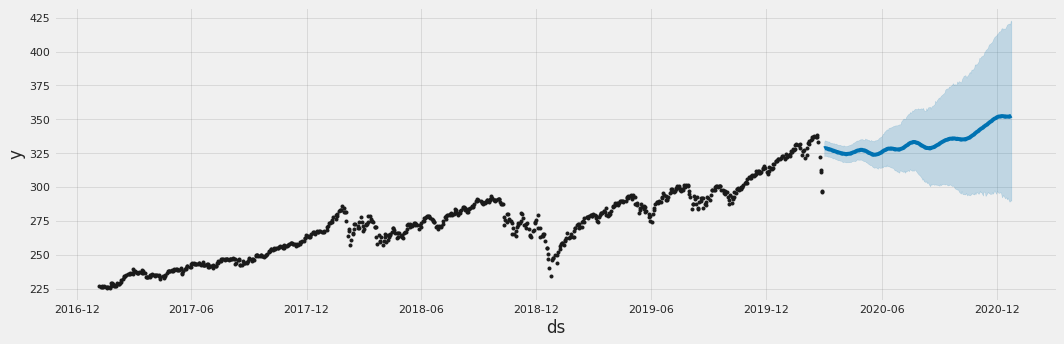

In [26]:
# Plotting the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst,
                 ax=ax)
plt.show()

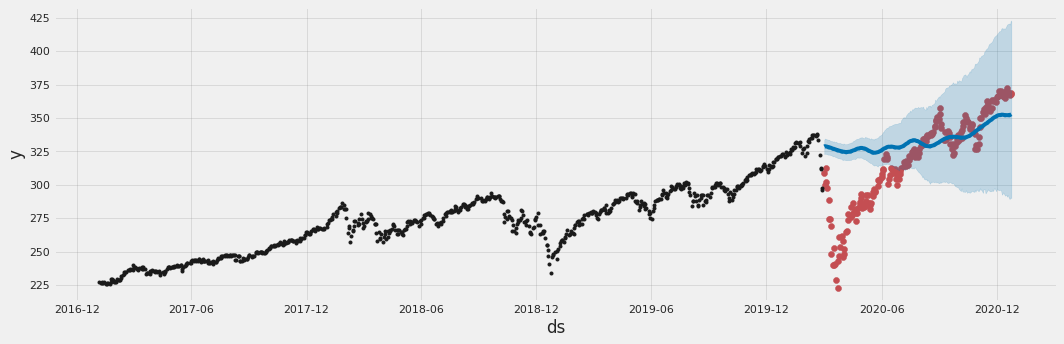

In [35]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['Close'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

I'm choosing Prophet model to predict the future stock prices. Since It looks more promising.

Let's predict a whole year!

In [42]:
future = model.make_future_dataframe(periods=365)
future.tail()

,ds
1151,2021-02-23
1152,2021-02-24
1153,2021-02-25
1154,2021-02-26
1155,2021-02-27


In [43]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1151,2021-02-23,366.072377,285.923416,461.931835
1152,2021-02-24,366.084307,280.763083,462.777155
1153,2021-02-25,366.185010,281.987418,462.105911
1154,2021-02-26,366.214771,282.108194,463.525506
1155,2021-02-27,372.823090,288.024342,470.657483


Let's see the predictions!

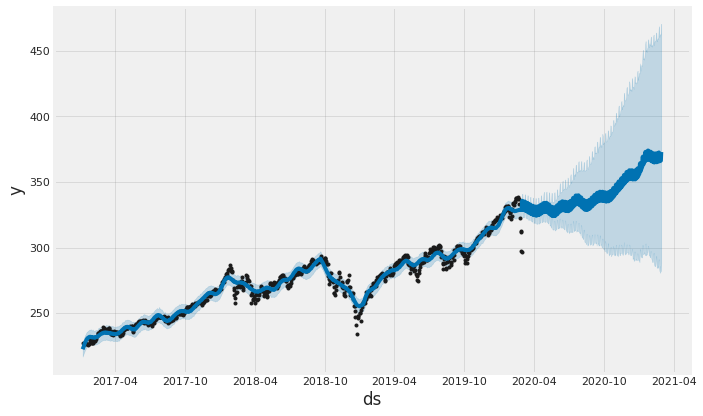

In [45]:

fig1 = model.plot(forecast)


In [46]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)